# Capstone Week 3
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df = pd.read_csv("../Transactions.csv", parse_dates=['refresh_date'])

In [3]:
df.head()

,Unnamed: 0,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M,redemption_curr,redemption_12M,new_Fund_added_12M,redemption_rate,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date
0,0,85102111664960504040,3096,6592,302,157,8,13,7,7,2,3,2,2,9,2,1.909702e+07,399995.834888,1.259993e+07,-231714.43334,-6.557185e+06,0,-0.012133,9.386941e+06,9.743856e+06,-9655.913728,0.0,-24116.993988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.431248e+06,1.066578e+07,0.0,0.0,2017-12-31
1,1,4492101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.468574e+04,0.000000,0.000000e+00,0.00000,0.000000e+00,0,0.000000,-7.102100e+03,0.000000e+00,-7583.640000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.468574e+04,0.000000e+00,0.0,0.0,2017-12-31
2,2,85102140943881291064,0,1,0,0,0,1,0,0,0,1,0,0,0,0,-7.164047e+04,0.000000,0.000000e+00,0.00000,-1.950000e+02,0,0.000000,-7.164047e+04,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.164047e+04,0.000000e+00,0.0,0.0,2017-12-31
3,3,85202121774856516280,1,0,0,0,1,0,0,0,1,0,0,0,2,2,3.425462e+05,0.000000,1.164760e+03,0.00000,0.000000e+00,1,0.000000,0.000000e+00,7.030151e+04,272244.700000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.425462e+05,0.000000e+00,0.0,0.0,2017-12-31
4,4,0360380,7,0,0,0,1,0,0,0,1,0,0,0,2,0,-2.262721e+05,0.000000,3.278145e+03,0.00000,0.000000e+00,0,0.000000,-1.113566e+05,-2.018566e+04,0.000000,0.0,-94729.890000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.315423e+05,-9.472989e+04,0.0,0.0,2017-12-31


In [4]:
# df['refresh_date'].dt.month

# df['year'] = df['refresh_date'].dt.year
# df['month'] = df['refresh_date'].dt.month

# filt = (df['year'] == 2020) & (df['month'] == 11)
# df.loc[filt, :]

## Make advisor dictionary mapper

In [5]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [6]:
adviser_lookup[10]

'0082583'

# Combine `sales_curr` and `sales_12M`

In [7]:
df['total_sales'] = df['sales_curr'] + df['sales_12M']

[Back to Top](#EDA)
# EDA

In [8]:
# !conda install -yc conda-forge pandas-profiling

In [9]:
# from pandas_profiling import ProfileReport

# missing_diagrams = {
#     'heatmap': True, 'dendrogram': True, 'matrix':True, 'bar': True,
# }

# profile = ProfileReport(df, title='Nuveen Profile Report', missing_diagrams=missing_diagrams)

# profile.to_file(output_file="nuveen_profiling.html")

# Data Cleaning

Before you change ANYTHING with the data - besides the above :) - do your train-test split

In [10]:
FEATURES = [
    'CONTACT_ID', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1',
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M',
    'redemption_rate', 'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'refresh_date',
]
TARGETS = 'total_sales'

In [11]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'CONTACT_ID', 'sales_curr', 'sales_12M', 
    'refresh_date', 'new_Fund_added_12M','no_of_Redemption_12M_1',
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 
    'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
    'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
    'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
    'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
    'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
    'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'redemption_curr', 
    'redemption_12M', 'redemption_rate', 'aum_AC_EQUITY', 
    'aum_AC_FIXED_INCOME_MUNI', 'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 
    'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 
    'aum_AC_TARGET', 'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 
    'aum_P_MF', 'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT',
]

## Partition training and testing

In [12]:
training_rows = df['refresh_date'].dt.year.isin([2017, 2018, 2019])
testing_rows = df['refresh_date'].dt.year.isin([2020])

X = df.loc[training_rows, FEATURES].copy()
y_reg = df.loc[training_rows, TARGETS].copy()
y_cl = df.loc[training_rows, 'new_Fund_added_12M'].copy()

y_holdout_test = df.loc[testing_rows, TARGETS].copy() # forget about this for now

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [13]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(series):
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [17]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [18]:
def extract_redemption(df):
    redemp_cols = [col for col in df.columns if 'redemption' in col.lower()]
    return df[redemp_cols].copy()

def replace_with_zero(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: min(0, x))
    return df

In [19]:
extract_redemption_trans = FunctionTransformer(extract_redemption)
replace_with_zero_trans = FunctionTransformer(replace_with_zero)

In [20]:
redemption_pipe = Pipeline([
    ('extract_redemption_trans', extract_redemption_trans),
    ('replace_with_zero_trans', replace_with_zero_trans),
    ('StandardScaler', StandardScaler())
])

In [21]:
pd.DataFrame(
    redemption_pipe.fit_transform(X_train),
    index=X_train.index,
    columns=[col for col in X_train.columns if 'redemption' in col.lower()]
)

,no_of_Redemption_12M_1,no_of_Redemption_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_Redemption_12M_10K,redemption_curr,redemption_12M,redemption_rate
122101,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
46186,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
41126,0.0,0.0,0.0,0.0,0.045743,-0.994636,0.004086
30070,0.0,0.0,0.0,0.0,0.067219,0.091516,0.004086
232410,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
...,...,...,...,...,...,...,...
190609,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
216465,0.0,0.0,0.0,0.0,0.068414,0.116706,0.004086
211136,0.0,0.0,0.0,0.0,0.068414,0.082220,0.004086
899,0.0,0.0,0.0,0.0,0.066797,0.116706,0.004086


In [22]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans)
])

y_train_reg = targ_pipe_reg.fit_transform(y_train_reg)
y_test_reg = targ_pipe_reg.transform(y_test_reg)

Transform the classification target

In [23]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)
y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

228198    1
240133    1
163658    1
176954    0
69498     1
         ..
239268    0
116033    0
238773    1
7527      1
11875     0
Length: 75075, dtype: int64

Create the pipeline for the features

In [24]:
from sklearn.preprocessing import PowerTransformer

In [25]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
    ('power_transformer', PowerTransformer())
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [26]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import metrics
import xgboost as xgb

### Linear Regression

In [28]:


lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [29]:
from sklearn.model_selection import cross_validate

In [30]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([1047274.97347135, 1143055.7520106 ,  989738.79913985])

Make a plot of predictions vs actual

In [31]:
y_test_reg_preds = lr.predict(X_test_prepared)

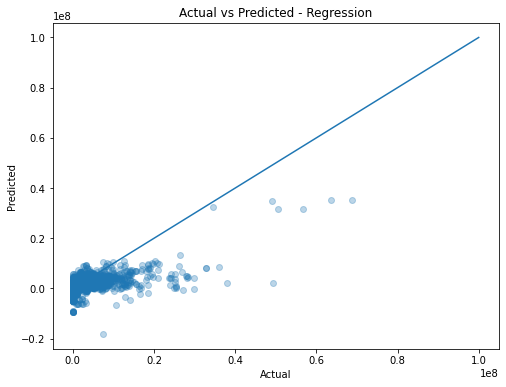

In [32]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds, alpha=0.3)

axes.plot([0, 100000000], [0,100000000])
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

In [33]:
def evaluate_model(model, X, y):
    cvscore=(
        np.mean(
            (-cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])))
    print("Cross Validation Score:\t", cvscore)
    
    print('R-squared:\t', model.score(X, y))
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(14,10))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, lim], [0, lim])
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds))
    print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y, preds, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y, preds))
    print('Explained Variance Score:', metrics.explained_variance_score(y, preds))
    print('Max Error:', metrics.max_error(y, preds))
    print('R^2:', metrics.r2_score(y, preds))

Cross Validation Score:	 829025.3246765134
R-squared:	 0.4175804908272076
-------------------------------------------------------
Mean Absolute Error (MAE): 214362.19457533673
Mean Squared Error (MSE): 695978692094.547
Root Mean Squared Error (RMSE): 834253.3740384554
Mean Absolute Percentage Error (MAPE): 1.3642550146896558e+20
Explained Variance Score: 0.4175897322041192
Max Error: 47313220.3548007
R^2: 0.4175804908272076


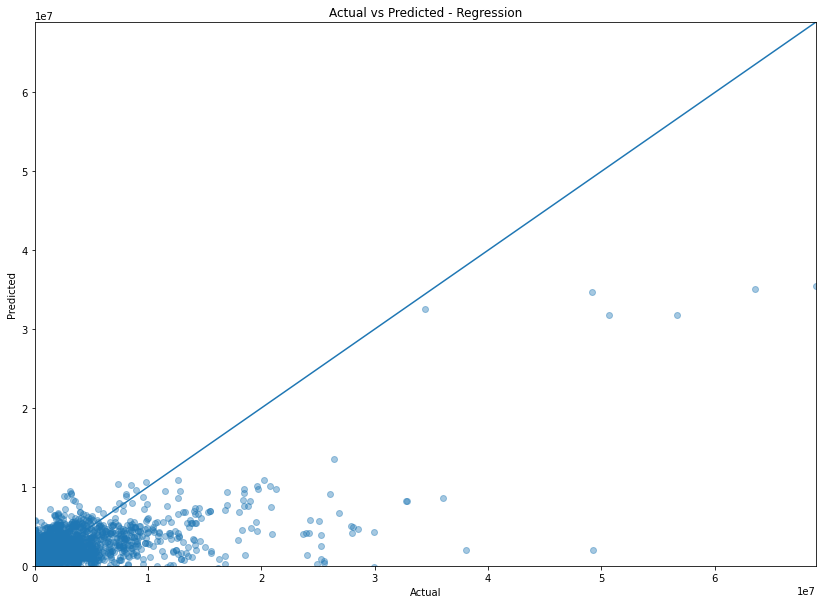

In [34]:
evaluate_model(lr, X_test_prepared, y_test_reg)

In [35]:
from sklearn.ensemble import RandomForestRegressor

### Random Forest

In [36]:
rfr = RandomForestRegressor(n_estimators=10)

In [37]:
yy = rfr.fit(X_train_prepared, y_train_reg)

Cross Validation Score:	 285426.1599389742
R-squared:	 0.9921544816941068
-------------------------------------------------------
Mean Absolute Error (MAE): 14607.13167337936
Mean Squared Error (MSE): 12802258608.367645
Root Mean Squared Error (RMSE): 113147.06628263785
Mean Absolute Percentage Error (MAPE): 5.201444280257133e+17
Explained Variance Score: 0.9921549151570518
Max Error: 11523659.324653398
R^2: 0.9921544816941068


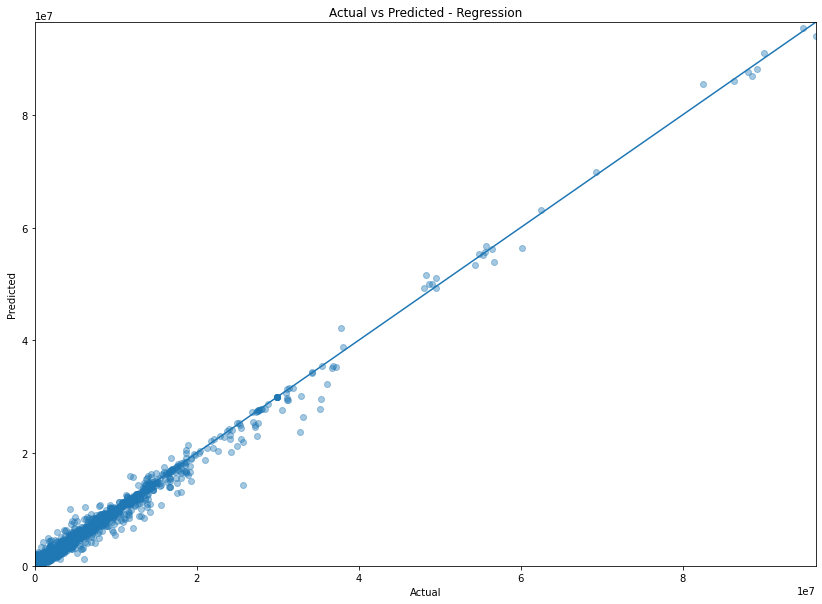

In [38]:
evaluate_model(rfr, X_train_prepared, y_train_reg)

## Classification

In [39]:
y_train_cl

122101    0
46186     0
41126     0
30070     1
232410    0
         ..
190609    0
216465    0
211136    1
899       0
242082    0
Length: 175175, dtype: int64

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_prepared, y_train_cl)

GradientBoostingClassifier()

In [42]:
gbc.predict_proba(X_test_prepared)[:, 1]

array([0.78076737, 0.53584119, 0.716439  , ..., 0.54576226, 0.8947188 ,
       0.39478911])

[Back to Top](#Index)
## Residual Analysis

In [43]:
y_test_reg_preds = rfr.predict(X_test_prepared)

In [44]:
# get the residuals
residuals = y_test_reg_preds - y_test_reg

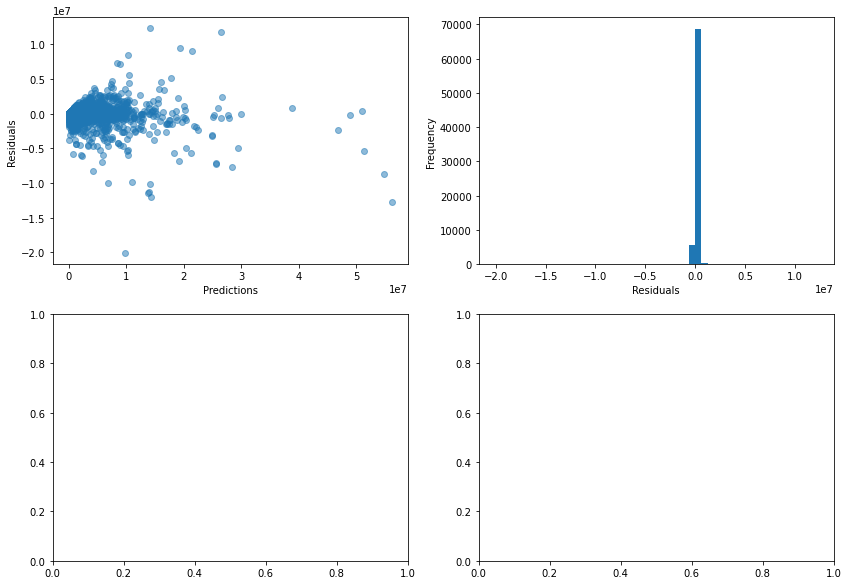

In [45]:
# plot predictions vs residuals
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# plot scatter plot on upper left plot
axes[0,0].scatter(x=y_test_reg_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel='Predictions', ylabel='Residuals')

# plot a hist on upper right plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [46]:
from statsmodels.api import qqplot

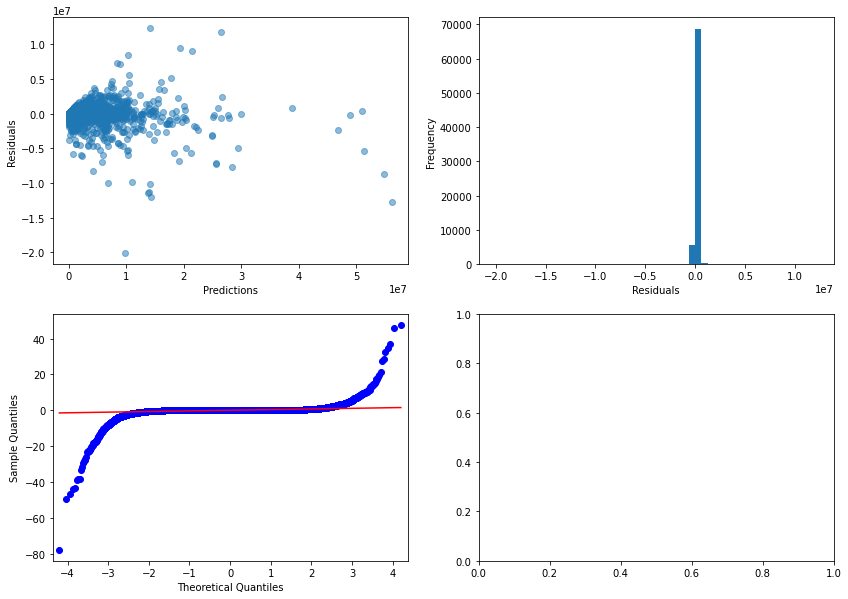

In [47]:
qqplot(residuals, fit=True, line='r', ax=axes[1,0])

In [48]:
# !pip install scikit-plot

In [49]:
import scikitplot as skplt

In [50]:
def evaluate_classifier(X, y, model):
    pass
    # print classification report
    # create lift charts
    # create gains charts

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# rf = RandomForestClassifier()

# rf.fit(X_train_prepared, y_train_cl)

In [53]:
y_test_cl_preds = gbc.predict_proba(X_test_prepared)

In [54]:
y_test_cl_preds

array([[0.21923263, 0.78076737],
       [0.46415881, 0.53584119],
       [0.283561  , 0.716439  ],
       ...,
       [0.45423774, 0.54576226],
       [0.1052812 , 0.8947188 ],
       [0.60521089, 0.39478911]])

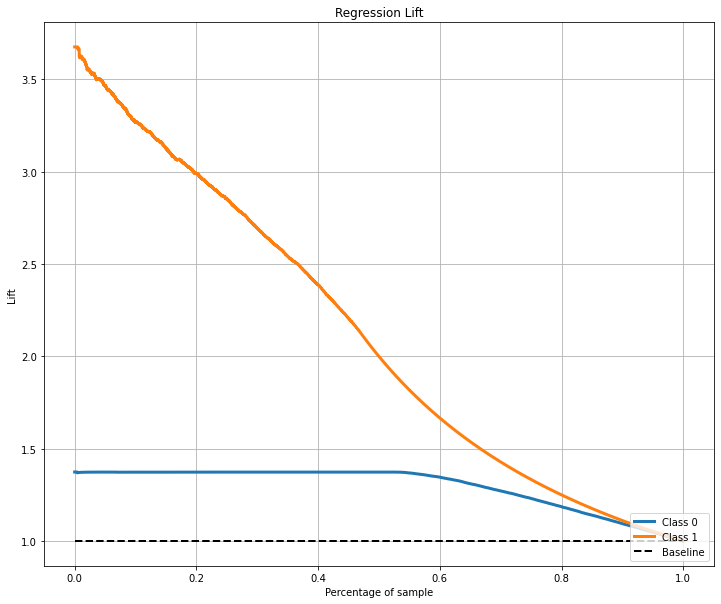

In [55]:
skplt.metrics.plot_lift_curve(y_test_cl, y_test_cl_preds, figsize=(12,10), title="Regression Lift");

In [56]:
np.sort(y_test_cl_preds)[:10]

array([[0.21923263, 0.78076737],
       [0.46415881, 0.53584119],
       [0.283561  , 0.716439  ],
       [0.00284318, 0.99715682],
       [0.14989539, 0.85010461],
       [0.00284318, 0.99715682],
       [0.22760034, 0.77239966],
       [0.00340132, 0.99659868],
       [0.24201348, 0.75798652],
       [0.48175342, 0.51824658]])

In [57]:
y_test_reg

228198    269083.425
240133      3578.970
163658      9497.900
176954         0.000
69498      30529.080
             ...    
239268       399.720
116033         0.000
238773     20656.470
7527      157805.390
11875        509.420
Name: total_sales, Length: 75075, dtype: float64

In [58]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [59]:
results = pd.DataFrame(data=y_test_reg.values, columns=['actual'], index=y_test_reg.index)
results['reg_preds'] = y_test_reg_preds
results['decile'] = pd.qcut(results.reg_preds.rank(method='first'), q=10, labels=False, retbins=False)
results['decile'] = ((results['decile']+1)*-1)+11

In [60]:
deciles = results.groupby('decile').agg({'actual':['count', 'mean'], 'reg_preds': 'mean'})
deciles.to_excel('deciles.xlsx')

In [61]:
(y_train_reg==0).sum()

91290

In [62]:
y_holdout_test

250250        0.000
250251    68746.945
250252        0.000
250253        0.000
250254        0.000
            ...    
360320    81389.275
360321        0.000
360322     2511.930
360323   459756.265
360324   720594.820
Name: total_sales, Length: 110075, dtype: float64

In [63]:
a = df.loc[testing_rows]

In [64]:
b = a.groupby(['CONTACT_ID']).agg({'total_sales':sum,'aum_AC_EQUITY':sum, 
    'aum_AC_FIXED_INCOME_MUNI':sum, 'aum_AC_FIXED_INCOME_TAXABLE':sum, 'aum_AC_MONEY':sum, 
    'aum_AC_MULTIPLE':sum, 'aum_AC_PHYSICAL_COMMODITY':sum, 'aum_AC_REAL_ESTATE':sum, 
    'aum_AC_TARGET':sum})

In [65]:
c = b.sort_values(['total_sales'], ascending=False)
c['decile'] = pd.qcut(c.total_sales.rank(method='first'), q=10, labels=False, retbins=False)
c['decile'] = ((c['decile']+1)*-1)+11
pies = c.groupby(['decile']).agg({'total_sales':sum,'aum_AC_EQUITY':sum, 
    'aum_AC_FIXED_INCOME_MUNI':sum, 'aum_AC_FIXED_INCOME_TAXABLE':sum, 'aum_AC_MONEY':sum, 
    'aum_AC_MULTIPLE':sum, 'aum_AC_PHYSICAL_COMMODITY':sum, 'aum_AC_REAL_ESTATE':sum, 
    'aum_AC_TARGET':sum})

In [66]:
pies.to_excel('pies.xlsx')

In [67]:
pies

,total_sales,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET
decile,,,,,,,,,
1,20816875876.269,2235439105.323,29082498295.930,2379053596.384,140792295.171,655895283.490,32482783.510,78830008.729,3707006552.402
2,2357789273.068,494555256.373,3986809622.970,772911130.288,4320119.220,170993053.596,9914349.610,48990057.640,488921046.303
3,666029134.720,-260604400.987,737440443.266,-25407089.954,1865223.640,94786740.884,6761582.162,2008941.331,141962180.869
4,187722140.839,-331167633.268,505352949.804,195993337.904,0.000,-43546518.575,10649059.668,21752671.545,64285290.731
5,41495141.614,-556366028.668,-39276551.599,15987862.834,67576.200,-34361944.667,11687290.201,16867908.345,64113665.704
6,2867974.888,-277916730.704,21618118.359,58535242.608,0.000,-64552741.130,12326058.505,4598117.975,27088640.703
7,0.000,-56011059.214,-54716097.272,34447377.303,0.000,-91271319.367,13140549.587,0.000,20062842.000
8,0.000,-100521097.719,413714574.911,70570964.723,0.000,-39760809.993,13432561.915,16049989.120,677472.367
9,0.000,51431845.604,-82958119.813,177130732.823,0.000,39330964.156,10871858.085,45384715.970,21769475.660


In [68]:
deciles

actual               reg_preds
        count        mean        mean
decile                               
1        7508 1580127.910 1563151.883
2        7507  157991.536  159982.789
3        7508   40686.621   39817.172
4        7507   10418.974    8937.704
5        7507    2872.786    1214.499
6        7508     242.453       0.000
7        7507     392.638       0.000
8        7508     526.340       0.000
9        7507     353.570       0.000
10       7508     805.208       0.000